<h1 align="center"> Pre-trained models with Resnet-18 for Concrete Crack Images Classification</h1>

***
AI Capstone Project with Deep Learning: Week 4

<h2 id="download_data">Download Data</h2>

In this section, you are going to download the data from IBM object storage using <b>wget</b>, then unzip them.  <b>wget</b> is a command the retrieves content from web servers, in this case its a zip file. Locally we store the data in the directory  <b>/resources/data</b> . The <b>-p</b> creates the entire directory tree up to the given directory.


First, we download the file that contains the images, if you dint do this in your first lab uncomment:


In [1]:
# !wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip -P /resources/data

We then unzip the file, this ma take a while:

In [2]:
#!unzip -q  /resources/data/concrete_crack_images_for_classification.zip -d  /resources/data

We then download the files that contain the negative images:


<h2 id="auxiliary">Imports and Auxiliary Functions</h2>

The following are the libraries we are going to use for this lab:

In [3]:
import os
import glob
import numpy as np

import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
from torch import optim 
torch.manual_seed(0)

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

<h2 id="data_class">Dataset Class</h2>


In this section, we will use the previous code to build a dataset class. As before, make sure the even samples are positive, and the odd samples are negative.  If the parameter <code>train</code> is set to <code>True</code>, use the first 30 000  samples as training data; otherwise, the remaining samples will be used as validation data. Do not forget to sort your files so they are in the same order.  


In [4]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="./resources/data"
        positive="Positive"
        negative="Negative"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)    
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        
        image=Image.open(self.all_files[idx])
        y=self.Y[idx]
          
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

<h2 id="trasform_Data_object">Transform Object and Dataset Object</h2>

Create a transform object, that uses the <code>Compose</code> function. First use the transform <code>ToTensor()</code> and followed by <code>Normalize(mean, std)</code>. The value for <code> mean</code> and <code>std</code> are provided for you.


In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform =transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)])

Create object for the training data  <code>dataset_train</code> and validation <code>dataset_val</code>. Use the transform object to convert the images to tensors using the transform object:


In [6]:
train_dataset = Dataset(transform=transform,train=True)
validation_dataset = Dataset(transform=transform,train=False)

We  can find the shape of the image:

In [7]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

We see that it's a color image with three channels:

In [8]:
size_of_image=3*227*227
size_of_image

154587

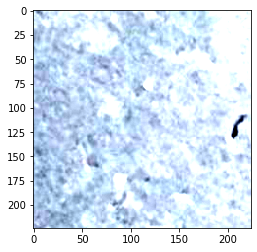

In [13]:
img = np.transpose(train_dataset[1][0], (1,2,0)).numpy()
img = np.clip(img, 0, 1)
plt.imshow(img)

<h2 > Train the Model <h2>

<b>Model Object:</b>

In [23]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad=False
model.fc=nn.Linear(512, 2)

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<b>Optimizer:</b>

In [25]:
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=0.003)

<b>Criterion:</b>

In [26]:
criterion = nn.CrossEntropyLoss()

<b>Data Loader Training and Validation:</b>

In [27]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=15)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=15)

<b>Train Model with 20 epochs</b>

In [28]:
n_epochs = 20
loss_list = []
accuracy_list= []
n_test = len(validation_dataset)

for epoch in range(n_epochs):
    loss_sublist = []
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        model.train()
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        loss_sublist.append(loss.data.item())
        loss.backward()
        optimizer.step()
    loss_list.append(np.mean(loss_sublist))
    print("Epoch: {}, Loss: {}".format(epoch+1, np.mean(loss_sublist)))
        
    correct = 0
    for x_test, y_test in validation_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        z = model(x_test)
        _, yhat = torch.max(z.data, dim=1)
        correct += (yhat == y_test).sum().item()
    accuracy = correct/n_test
    accuracy_list.append(accuracy)
    print("accuracy: {}".format(accuracy))

Epoch: 1, Loss: 0.026047022202355833
accuracy: 0.9919
Epoch: 2, Loss: 0.018376324952963385
accuracy: 0.9915
Epoch: 3, Loss: 0.01739796675858036
accuracy: 0.9924
Epoch: 4, Loss: 0.01628373377100039
accuracy: 0.9926
Epoch: 5, Loss: 0.014100333772093437
accuracy: 0.9916
Epoch: 6, Loss: 0.01298450330792746
accuracy: 0.9911
Epoch: 7, Loss: 0.012551981596051429
accuracy: 0.988
Epoch: 8, Loss: 0.013527245431871261
accuracy: 0.9911
Epoch: 9, Loss: 0.01386262813409564
accuracy: 0.9905
Epoch: 10, Loss: 0.010634389191009274
accuracy: 0.9915
Epoch: 11, Loss: 0.009809893859310042
accuracy: 0.9925
Epoch: 12, Loss: 0.00965659362633139
accuracy: 0.992
Epoch: 13, Loss: 0.012159308946937779
accuracy: 0.9893
Epoch: 14, Loss: 0.008457291113138157
accuracy: 0.9912
Epoch: 15, Loss: 0.009320279708613667
accuracy: 0.9923
Epoch: 16, Loss: 0.010870671359309594
accuracy: 0.9907
Epoch: 17, Loss: 0.0069861762929606976
accuracy: 0.9925
Epoch: 18, Loss: 0.007358291590886045
accuracy: 0.9919
Epoch: 19, Loss: 0.009731

**accuracy**

In [58]:
print(accuracy)

0.9912


**the plot of loss**

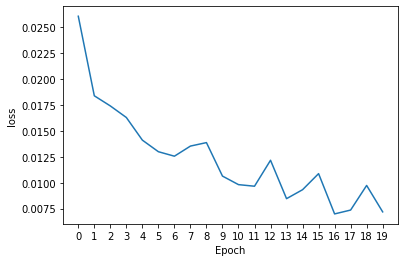

In [59]:
plt.plot(loss_list)
plt.xticks(range(20))
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.show()

**get the misclassified images**

In [45]:
y_test_label = []
y_hat_label = []

In [46]:
with torch.no_grad():
    for x_test, y_test in validation_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)   
        z = model(x_test)
        _, yhat = torch.max(z.data, dim=1)
        
        y_test_label.extend(y_test.tolist())
        y_hat_label.extend(yhat.tolist())

In [47]:
misclassified_samples = [i for i in range(len(y_hat_label)) if y_test_label[i]!=y_hat_label[i]]
print(len(misclassified_samples))
print(misclassified_samples)

88
[18, 45, 62, 269, 452, 550, 763, 785, 1035, 1161, 1177, 1178, 1212, 1244, 1583, 1935, 2429, 2540, 2624, 2647, 2703, 2945, 3100, 3265, 3377, 3474, 3640, 3653, 3897, 4097, 4270, 4600, 4652, 4673, 4759, 4827, 4928, 5282, 5305, 5352, 5427, 5543, 5603, 5852, 5997, 6070, 6205, 6275, 6533, 6544, 6617, 6682, 6687, 6790, 6930, 7016, 7294, 7352, 7454, 7474, 7560, 7587, 7594, 7621, 8032, 8093, 8099, 8276, 8395, 8511, 8631, 8755, 8906, 8944, 8970, 9023, 9045, 9219, 9405, 9449, 9495, 9746, 9753, 9761, 9762, 9843, 9930, 9957]


In [55]:
for m in range(4):
    i = misclassified_samples[m]
    print("sample {} yhat {} y {}".format(i, torch.tensor([y_hat_label[i]], dtype=torch.long), torch.tensor([y_test_label[i]], dtype=torch.long)))

sample 18 yhat tensor([0]) y tensor([1])
sample 45 yhat tensor([1]) y tensor([0])
sample 62 yhat tensor([0]) y tensor([1])
sample 269 yhat tensor([1]) y tensor([0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


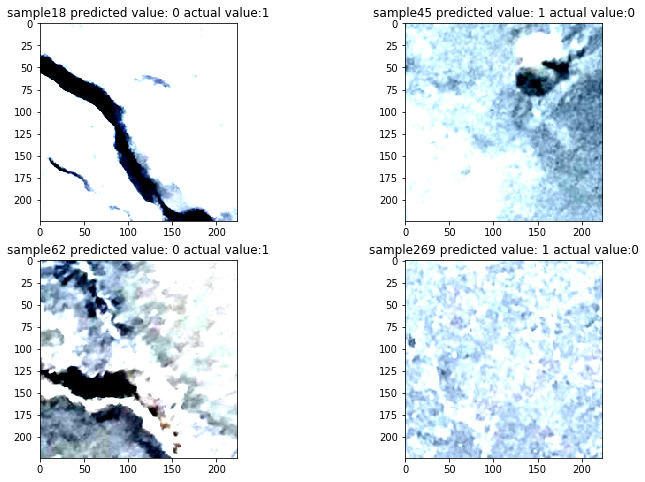

In [48]:
plt.figure(22, figsize=(12,8))
for m in range(4):
    i = misclassified_samples[m]
    img = np.transpose(validation_dataset[i][0], (1,2,0))
    plt.subplot(221+m)
    plt.title("sample{} predicted value: {} actual value:{}".format(i, y_hat_label[i], y_test_label[i]))
    plt.imshow(img)